<a href="https://colab.research.google.com/github/nightted/ML-LeeHongYi-HW/blob/master/HW2%20-%20Logistic%20Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data 

In [ ]:
!gdown --id '1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92' --output data.tar.gz
!tar -zxvf data.tar.gz
!ls

Downloading...
From: https://drive.google.com/uc?id=1KSFIRh0-_Vr7SdiSCZP1ItV7bXPxMD92
To: /content/data.tar.gz
6.11MB [00:00, 28.3MB/s]
data/
data/sample_submission.csv
data/test_no_label.csv
data/train.csv
data/X_test
data/X_train
data/Y_train
data  data.tar.gz  drive  sample_data


# Data input and reshape

In [ ]:
import numpy as np

np.random.seed(0)
X_train_fpath = './data/X_train'
Y_train_fpath = './data/Y_train'
X_test_fpath = './data/X_test'
output_fpath = './output_{}.csv'

# Totally 54256 (number of data) X 511 (number of feat.)
# Parse csv files to numpy array
with open(X_train_fpath) as f:
    # next() 的原因是不需要 feature 那行 
    next(f)
    #一行代表一個 data , strip 掉換行符號後,再把每個 data的 feature 弄成 list
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
with open(Y_train_fpath) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
with open(X_test_fpath) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    

X_mean = np.mean(X_train[:,:],axis=0).reshape(1,-1) #reshpae(1,-1) 代表 row 搞成一列 , column -1 的意思是 column 數自動補齊計算.
X_std = np.std(X_train[:,:],axis=0).reshape(1,-1)


In [ ]:
Split_ratio = 0.1
Validate_len = int(np.round(Split_ratio*X_train.shape[0]))

X_validate = X_train[:Validate_len,:]
Y_validate = Y_train[:Validate_len]
X_training = X_train[Validate_len:,:]
Y_training = Y_train[Validate_len:]

print ("Validate_shape:",X_validate.shape,Y_validate.shape,"Training_shape:",X_training.shape,Y_training.shape)

Validate_shape: (5426, 510) (5426,) Training_shape: (48830, 510) (48830,)


#Normalize the data

In [ ]:
X_training = (X_training[:,:] - X_mean) / (X_std+1e-8)
X_validate = (X_validate[:,:] - X_mean) / (X_std+1e-8)
X_test = (X_test[:,:] - X_mean) / X_std # test data must normalized with the mean & std of training data
print(X_training.shape,X_validate.shape,X_test.shape)

(48830, 510) (5426, 510) (27622, 510)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_size = X_training.shape[0]
Validate_size = X_validate.shape[0]
test_size = X_test.shape[0]
data_dim = X_train.shape[1]

print('Size of training data:{}'.format(train_size))
print('Size of validate data:{}'.format(Validate_size))
print('Size of testing data:{}'.format(test_size))
print('Data dimension:{}'.format(data_dim))

Size of training data:48830
Size of validate data:5426
Size of testing data:27622
Data dimension:510


# Define the function of training

In [ ]:
import random

def _shuffle(X, Y):
    # This function shuffles two equal-length list/array, X and Y, together.
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])

#Randomize the priority of the data
def shuffle(X_data,Y_data):
    
    data_len = X_data.shape[0]
    random_pri = []
    li = list(range(data_len))
    
    while len(li)>0 :
        
        select = random.randint(0,len(li)-1)
        random_pri.append(li.pop(select))
            
    return X_data[random_pri],Y_data[random_pri]

#Calculate Cross Entropy of all data
def CrossEntorpy(y_train,y_predict):
    
    return -y_train@np.log(y_predict)-(1-y_train)@np.log(1-y_predict)

def sigmoid(z) :
    
    return np.clip(1/(1+np.exp(-z)),1e-8,1-1e-8)

def sigmoid_linearinput(X,w,b):
    
    linear = X@w+b
    return sigmoid(linear)

def gradient(y_hat,X,w,b,reg = None, lamb = 0.01):
    
    y_pred = sigmoid_linearinput(X,w,b)
    #For L1 norm
    #這邊記得要 copy w , 不然 w 是 mutable object 會再function內被改動!!
    reg_term = np.copy(w)
    if reg == "L1": 
      if np.sum(reg_term!=0) == len(reg_term):
        reg_term = reg_term/np.abs(reg_term)
      else: 
        idx = 0
        for ele in reg_term==0:
          if ele:
            reg_term[idx] = 0
          else :
            reg_term[idx] = reg_term[idx]/np.abs(reg_term[idx])
          idx+=1
      
      return -1*X.T@(y_hat - y_pred) + lamb*reg_term , -1*np.sum(y_hat - y_pred) 

    #For L1 norm
    if reg == "L2":
      return -1*X.T@(y_hat - y_pred) + 2*lamb*reg_term , -1*np.sum(y_hat - y_pred)

    #For no regularization
    else:
      return -1*X.T@(y_hat - y_pred) , -1*np.sum(y_hat - y_pred)

#Calculate the accuracy of model 
def accuracy(y_train,y_pred):
    
    return (1-sum(np.round(np.abs(y_pred-y_train)))/y_train.shape)*100

#The main training process
def trianing(epoch, train_method, Y_training, Y_validate, X_training, X_validate,reg,lamb, w=None, b=None, lr = 0.01, mini_batch_size = 1000):
    
    # accuracy & loss collecting
    Training_accuracy = []
    Training_loss = []
    Validate_accuracy = []
    Validate_loss = []
    
    #parameter w,b initialize
    w = np.zeros(X_training.shape[1])
    b = np.zeros(1)
    #for Adagrad 
    G_w = np.zeros(X_training.shape[1])
    G_b = np.zeros(1)
    eps = 1
    #for RMSprop & Adams
    p = 0.9
    #for momentum 
    mass = 0.01
    velocity_w = np.zeros(X_training.shape[1])
    velocity_b = np.zeros(1)
    
    for i in range(epoch):
        
        _shuffle(X_training,Y_training) # Shuffle the training data to the increase the variation of mini-batch
        
        for batch_count in range(int(np.floor(X_training.shape[0]/mini_batch_size))+1):
            
            X = X_training[batch_count*mini_batch_size:(batch_count+1)*mini_batch_size]
            Y = Y_training[batch_count*mini_batch_size:(batch_count+1)*mini_batch_size]
            w_grad , b_grad = gradient(Y,X,w,b,reg=reg,lamb=lamb)

            if train_method == "SGD":               
                
                w = w - lr*w_grad
                b = b - lr*b_grad
                
            if train_method == "Adagrad":  
                          
                G_w += w_grad**2
                G_b += b_grad**2

                w = w - lr/(np.sqrt(G_w+eps))*w_grad
                b = b - lr/(np.sqrt(G_b+eps))*b_grad
                
            if train_method == "RMSProp":  
                             
                G_w = p*G_w + (1-p)*w_grad**2
                G_b = p*G_b + (1-p)*b_grad**2

                w = w - lr/(np.sqrt(G_w+eps))*w_grad
                b = b - lr/(np.sqrt(G_b+eps))*b_grad
                
            if train_method == "Momentum":
                
                velocity_w = mass*velocity_w + lr*w_grad
                velocity_b = mass*velocity_b + lr*b_grad
                
                w = w - velocity_w
                b = b - velocity_b
                         
            if train_method == "Adams":
                  
                G_w = p*G_w + (1-p)*w_grad**2
                G_b = p*G_b + (1-p)*b_grad**2
                velocity_w = mass*velocity_w + (1-mass)*w_grad
                velocity_b = mass*velocity_b + (1-mass)*b_grad

                w = w - lr/(np.sqrt((G_w/(1-p))+eps))*(velocity_w/(1-mass))
                b = b - lr/(np.sqrt((G_b/(1-p))+eps))*(velocity_b/(1-mass))

        # Collect the accuracy & loss of "training" data
        Train_loss = CrossEntorpy(Y_training , sigmoid_linearinput(X_training,w,b))/X_training.shape[0]
        Train_accu = accuracy(Y_training , sigmoid_linearinput(X_training,w,b))
        Training_loss.append(Train_loss)
        Training_accuracy.append(Train_accu) 
        
        # Collect the accuracy & loss of "Validate" data
        Valid_loss = CrossEntorpy(Y_validate , sigmoid_linearinput(X_validate,w,b))/X_validate.shape[0]
        Valid_accu = accuracy(Y_validate , sigmoid_linearinput(X_validate,w,b))
        Validate_loss.append(Valid_loss)
        Validate_accuracy.append(Valid_accu)
        
        print("Epoch:",i,"Training_loss:",Train_loss,"Training_accuracy:",Train_accu,"Validate_loss:",Valid_loss,"Validate_accuracy:",Valid_accu)
        
    return Training_loss ,Training_accuracy ,Validate_loss ,Validate_accuracy
        

In [ ]:
step = 5
start_lambda = 0.001
Training_loss = np.zeros([step,50])
Training_accuracy = np.zeros([step,50])
Validate_loss = np.zeros([step,50])
Validate_accuracy = np.zeros([step,50])
for i in range(step):
  print("now in step:",i+1 , "the lambda is:",start_lambda*pow(10,i))
  Training_loss[i,:] ,Training_accuracy[i,:] ,Validate_loss[i,:] ,Validate_accuracy[i,:] = trianing(50,"Adams", Y_training, Y_validate, X_training, X_validate,"L1",start_lambda*pow(10,i))

now in step: 1 the lambda is: 0.001
Epoch: 0 Training_loss: 0.48827629441842213 Training_accuracy: [80.30309236] Validate_loss: 0.47892580125329187 Validate_accuracy: [80.53814965]
Epoch: 1 Training_loss: 0.4401050361004101 Training_accuracy: [83.06573828] Validate_loss: 0.4289799582164014 Validate_accuracy: [83.06302986]
Epoch: 2 Training_loss: 0.4045162011635161 Training_accuracy: [84.85766947] Validate_loss: 0.3930622324423731 Validate_accuracy: [84.75856985]
Epoch: 3 Training_loss: 0.3759123838084723 Training_accuracy: [85.9922179] Validate_loss: 0.36468938129260015 Validate_accuracy: [85.95650571]
Epoch: 4 Training_loss: 0.3526320594541787 Training_accuracy: [86.82572189] Validate_loss: 0.3417927700258212 Validate_accuracy: [86.78584593]
Epoch: 5 Training_loss: 0.3337344894223651 Training_accuracy: [87.3725169] Validate_loss: 0.3234753230662181 Validate_accuracy: [87.35716919]
Epoch: 6 Training_loss: 0.31822183776312807 Training_accuracy: [87.75957403] Validate_loss: 0.30857088132

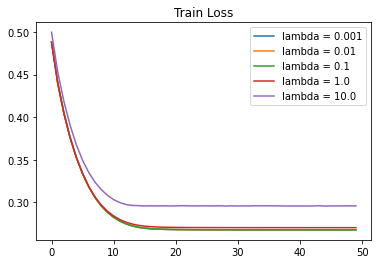

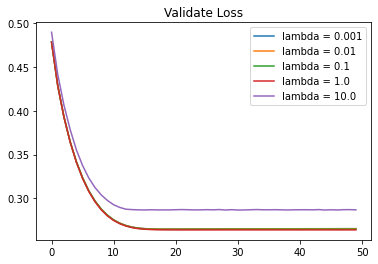

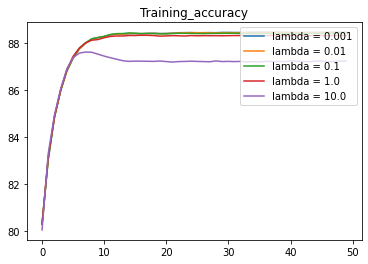

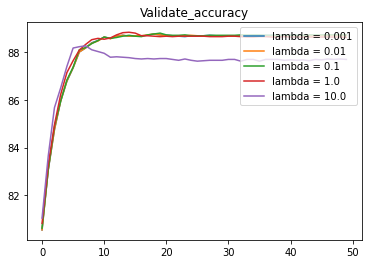

In [ ]:
import matplotlib.pyplot as plt

# Loss curve
for i in range(step):
  plt.plot(Training_loss[i].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Train Loss')
plt.legend(loc='upper right')
plt.savefig('Training_loss.png')
plt.show()

for i in range(step):
  plt.plot(Validate_loss[i].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Validate Loss')
plt.legend(loc='upper right')
plt.savefig('Validate_loss.png')
plt.show()

# Accuracy curve
for i in range(step):
  plt.plot(Training_accuracy[i].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Training_accuracy')
plt.legend(loc='upper right')
plt.savefig('Training_accuracy.png')
plt.show()

for i in range(step):
  plt.plot(Validate_accuracy[i].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Validate_accuracy')
plt.legend(loc='upper right')
plt.savefig('Validate_accuracy.png')
plt.show()


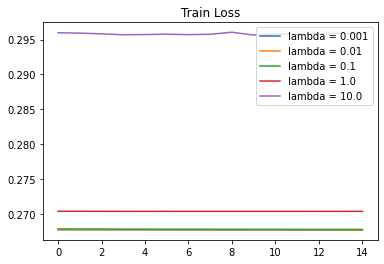

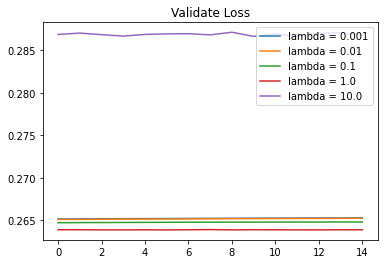

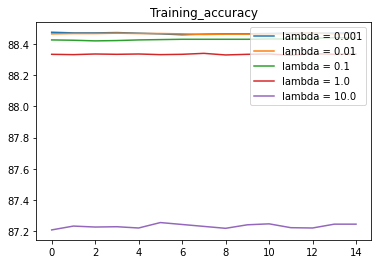

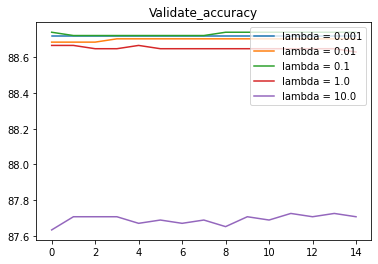

In [ ]:
# Loss curve
for i in range(step):
  plt.plot(Training_loss[i,35:].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Train Loss')
plt.legend(loc='upper right')
plt.savefig('Training_loss.png')
plt.show()

for i in range(step):
  plt.plot(Validate_loss[i,35:].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Validate Loss')
plt.legend(loc='upper right')
plt.savefig('Validate_loss.png')
plt.show()

# Accuracy curve
for i in range(step):
  plt.plot(Training_accuracy[i,35:].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Training_accuracy')
plt.legend(loc='upper right')
plt.savefig('Training_accuracy.png')
plt.show()

for i in range(step):
  plt.plot(Validate_accuracy[i,35:].T,label= "lambda = {}".format(start_lambda*pow(10,i)))
plt.title('Validate_accuracy')
plt.legend(loc='upper right')
plt.savefig('Validate_accuracy.png')
plt.show()